In [1]:
import os
import math
import time
import struct
import json
import pandas as pd
import networkx as nx
import numpy as np
import numpy.linalg as npla
import scipy
import scipy.sparse.linalg as spla
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
%matplotlib tk



In [2]:
def pagerank(E, return_vector = False, max_iters = 1000, tolerance = 1e-6):
    """compute page rank from sparse csr adjacency matrix

    Inputs:
      E: adjacency matrix with links going from cols to rows.
         E is a matrix of 0s and 1s, where E[i,j] = 1 means 
         that web page (vertex) j has a link to web page i.
      return_vector = False: If True, return the eigenvector as well as the ranking.
      max_iters = 1000: Maximum number of power iterations to do.
      tolerance = 1e-6: Stop when the eigenvector norm changes by less than this.
      
    Outputs:
      ranking: Permutation giving the ranking, most important first
      vector (only if return_vector is True): Dominant eigenvector of PageRank matrix

    This computes page rank by using the power iteration method.
    """
    
    assert sparse.isspmatrix_csr(E), 'Must be a sparse matrix'
                
    nnz = sparse.csr_matrix.count_nonzero(E) 
    outdegree = np.array(E.sum(0))[0]
    nrows, n = E.shape
    assert nrows == n, 'E must be square'
    assert np.max(E) == 1 and np.sum(E) == nnz, 'E must contain only zeros and ones'
    np.seterr(divide='ignore', invalid='ignore')

    m = 0.15
    m_not = 1-m
    e = np.ones(n)
    v = e / npla.norm(e)
    
    e = np.zeros(n)
    for c in range(n):
        if outdegree[c] == 0:
            e[c] = 1

    for iteration in range(max_iters):
        oldv = v
        
        # this line may cause a divide by zero warning since outdegree may have 0 elements which sets these values to inf
        #, however the function multiply treats inf values as 0 so this issue is accounted for
        t = v/outdegree
        v = E@t
        s = m/n*np.sum(oldv)
        val = e@oldv
        v = v - np.multiply(e,oldv)/(n-1)
        
        s = s + m_not*val/(n-1)
        v = m_not*v+s
        
        eigval = npla.norm(v)
        v = v / eigval
        
        if npla.norm(v - oldv) < tolerance:
            break
    
    if npla.norm(v - oldv) < tolerance:
        print('Dominant eigenvalue is %f after %d iterations.\n' % (eigval, iteration+1))
    else:
        print('Did not converge to tolerance %e after %d iterations.\n' % (tolerance, max_iters))

    # Check that the eigenvector elements are all the same sign, and make them positive
    assert np.all(v > 0) or np.all(v < 0), 'Error: eigenvector is not all > 0 or < 0'
    vector = np.abs(v)
        
    #  Sort the eigenvector and reverse the permutation to get the rankings.
    ranking = np.argsort(vector)[::-1]

    if return_vector:
        return ranking, vector
    else:
        return ranking

In [3]:
E = np.load('PageRankEG1.npy')
%time r, v = pagerank(sparse.csr_matrix(E), return_vector = True)
print('r =', r)
print('v =', np.log10(v))

Dominant eigenvalue is 1.000000 after 19 iterations.

CPU times: user 2.63 ms, sys: 713 µs, total: 3.34 ms
Wall time: 2.72 ms
r = [0 2 3 1]
v = [-0.15708945 -0.57140999 -0.26378045 -0.41759526]


[-0.52183986 -1.89818289 -0.87625968 -1.38722144]


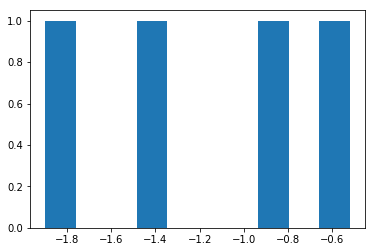

In [4]:
# making histogram for PageRankEG1
v_log = np.log2(v)
print(v_log)
num_bins = len(v_log)
n, bins, patches = plt.hist(v_log)
plt.show()

In [5]:
E = np.load('PageRankEG2.npy')
%time r, v = pagerank(sparse.csr_matrix(E), return_vector = True)
print('r =', r)
print('v =', np.log10(v))

Dominant eigenvalue is 1.000000 after 2 iterations.

CPU times: user 1.34 ms, sys: 78 µs, total: 1.42 ms
Wall time: 1.38 ms
r = [3 2 1 0 4]
v = [-0.39208568 -0.39208568 -0.23827082 -0.23827082 -1.21599442]


In [6]:
E = np.load('PageRankEG3.npy')
sitename = open('PageRankEG3.nodelabels').read().splitlines()
%time r = pagerank(sparse.csr_matrix(E))
print('r[:10] =', r[:10])
print()
for i in range(10):
    print('rank %d is page %3d: %s' % (i, r[i], sitename[r[i]]))

Dominant eigenvalue is 1.000000 after 56 iterations.

CPU times: user 9.49 ms, sys: 229 µs, total: 9.72 ms
Wall time: 9.76 ms
r[:10] = [  0   9  41 129  17  14   8  16  45  12]

rank 0 is page   0: http://www.harvard.edu
rank 1 is page   9: http://www.hbs.edu
rank 2 is page  41: http://search.harvard.edu:8765/custom/query.html
rank 3 is page 129: http://www.med.harvard.edu
rank 4 is page  17: http://www.gse.harvard.edu
rank 5 is page  14: http://www.hms.harvard.edu
rank 6 is page   8: http://www.ksg.harvard.edu
rank 7 is page  16: http://www.hsph.harvard.edu
rank 8 is page  45: http://www.gocrimson.com
rank 9 is page  12: http://www.hsdm.med.harvard.edu


In [8]:
E = sparse.load_npz('webGoogle.npz')
%time r,v = pagerank(E, True)
print("smallest v: ", min(v), "largest v: ", max(v))

Dominant eigenvalue is 1.000000 after 71 iterations.

CPU times: user 4.94 s, sys: 527 ms, total: 5.47 s
Wall time: 2.88 s
smallest v:  0.00013008094286806027 largest v:  0.11427415903137216
